In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.ticker as ticker

In [2]:
timepoint_path = '../../metadata/MBC/merged_tables_revisions1/timepoint_data.txt'
metadata_path = '../../metadata/MBC/merged_tables_revisions1/merged_key_metadata.txt'
multi_biopsy_path = '../../metadata/MBC/data_tables/multiple_biopsies_2022-02-01.txt'

probs_dir = '../../MBC/ATAC_nucleosome_profiling/analysis/logreg_results/'
feature_type = '5e-4_qval'

In [3]:
#import per patient metadata
metadata = pd.read_csv(metadata_path,sep='\t')
metadata = metadata[['patient_id','TNBC_ULPWGS_ID','PatientID_09204','PatientID_05246','merged_PrimaryEstrogenStatus','merged_MetsEstrogenStatus','merged_ER_switch','merged_DeathCensor']]
metadata  = metadata.drop_duplicates().reset_index(drop=True)
print('samples',len(metadata))

#import data for patients with multiple biopsies
multiple_biopsy_data = pd.read_csv(multi_biopsy_path, sep='\t')
#remove patients with an unknown timeline
multiple_biopsy_data = multiple_biopsy_data[~(multiple_biopsy_data['time_from_met_to_biopsy_days']=='unknown')]
#remove a primary biopsy with unknown subtype
multiple_biopsy_data = multiple_biopsy_data[~(multiple_biopsy_data['ER_status_biopsy']=='none')]


#import cfDNA timepoints for patients where this is known
timepoint_data = pd.read_csv(timepoint_path, sep='\t')
#merge with sample specific timepoint data and retain all samples
timepoint_data = timepoint_data.merge(metadata, on = ['patient_id'], how = 'left')
print('timepoint data',len(timepoint_data))

#check that nothing got duplicated
print(len(timepoint_data['sample'].unique()))

del(metadata)

samples 139
timepoint data 40
40


In [4]:
#import predictions
feature_type = '5e-4_qval'
prob_path = probs_dir+feature_type+'_logreg_results/'+feature_type+'.probabilities.txt'
iterations = 1000
predictions = pd.read_csv(prob_path,sep='\t')
predictions['median_probability'] = predictions[[str(m) for m in range(iterations)]].median(axis=1)
predictions = predictions[['sample','median_probability','status']]
#merge with timepoint data
merged = predictions.merge(timepoint_data[['sample','verified_days_from_met_to_processing_date','patient_id','tumor_fraction']], on = 'sample')


In [5]:
color_dict = {'+':'tab:blue','-':'tab:orange','moderate':'tab:blue','low':[0.65, 0.79, 0.88]}


In [6]:
# #custom xtick spacing
# tick_spacing = {'MBC_1413':1,
#                 'MBC_1406':1,
#                 'MBC_1405':1,
#                 'MBC_1322':0.5,
#                 'MBC_1308':0.5,
#                 'MBC_1306':1,
#                 'MBC_1399':1,
#                 'MBC_1377':1,
#                 'MBC_1099':2,
#                 'MBC_1408':1,
#                 'MBC_331':0.5,
#                 'MBC_1312':0.5,
#                 'MBC_1404':0.5}

MBC_1404 + ['+' '-']
   patient_id  TNBC_ULPWGS_ID PatientID_09204 PatientID_05246  \
47   MBC_1404  TNBC_ULPWGS_73       09204_358             NaN   
46   MBC_1404  TNBC_ULPWGS_73       09204_358             NaN   

                                     reason_requested  \
47  Dan says ER+primary (subtype switch) Heather s...   
46  Dan says ER+primary (subtype switch) Heather s...   

   time_from_primary_to_met_days time_from_primary_to_biopsy_days  \
47                          3947                             3879   
46                          3947                                0   

    time_from_met_to_biopsy_days  \
47                           -68   
46                         -3947   

                                             location ER_status_biopsy  \
47  RIGHT BREAST, LATERAL ASPECT, CORE NEEDLE BIOP...                -   
46  RIGHT BREAST, UPPER CENTRAL, EXCISION FOR A MA...                +   

    last_before_cfDNA biopsy_type                        ER_status_note

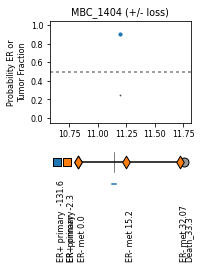

MBC_1158 low ['low' '+']
   patient_id TNBC_ULPWGS_ID PatientID_09204 PatientID_05246 reason_requested  \
33   MBC_1158            NaN             NaN       05246_444   subtype_switch   
32   MBC_1158            NaN             NaN       05246_444   subtype_switch   
31   MBC_1158            NaN             NaN       05246_444   subtype_switch   
30   MBC_1158            NaN             NaN       05246_444   subtype_switch   

   time_from_primary_to_met_days time_from_primary_to_biopsy_days  \
33                          1711                                0   
32                          1711                            -1037   
31                          1711                            -1114   
30                          1711                            -1121   

    time_from_met_to_biopsy_days  \
33                         -1711   
32                         -2748   
31                         -2825   
30                         -2832   

                                          

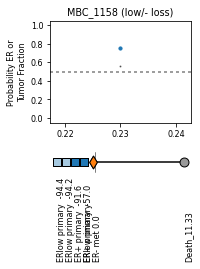

In [7]:
samples = multiple_biopsy_data['patient_id'].unique()
text_shift = -2
marker_size = 80

# for ID in samples:
for ID in ['MBC_1404','MBC_1158']:
    plt.rcParams.update({'font.size': 8})
    
    fig = plt.figure(figsize = (3,4))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(413)

    #ax1.tick_params(length=6, width=1.5)

    #plot predictions
    current_predictions = merged[merged['patient_id']==ID].sort_values(by='verified_days_from_met_to_processing_date')
    ax1.plot(np.round(current_predictions['verified_days_from_met_to_processing_date']/30,2), current_predictions['median_probability'], 
             alpha = 0.255, linewidth = 4,color='black', solid_capstyle = 'round', label = 'probability of ER+')    
    
    colors = np.where(current_predictions['median_probability']>0.5, 'tab:blue','tab:orange')
    ax1.scatter(np.round(current_predictions['verified_days_from_met_to_processing_date']/30,2), current_predictions['median_probability'], marker = 'o', s = 10, 
               facecolor = colors, zorder=4)    

    min_blood_draw = current_predictions['verified_days_from_met_to_processing_date'].min()/30
    max_blood_draw = current_predictions['verified_days_from_met_to_processing_date'].max()/30
    
    #plot tumor fraction
    ax1.plot(np.round(current_predictions['verified_days_from_met_to_processing_date']/30,2), current_predictions['tumor_fraction'], color='black', 
             marker = 'o', markersize = 1, alpha = 0.5, linewidth = 1, label = 'TFx')    
    
    #multi biopsy
    current = timepoint_data[timepoint_data['patient_id']==ID]
    
    #get key info
    met_status = current['merged_MetsEstrogenStatus'].unique()[0]
    prim_status = current['merged_PrimaryEstrogenStatus'].unique()[0]
    switch_status = current['merged_ER_switch'].unique()[0]
    
    #create timeline from met diagnosis to death/last follow up in months
    #print(ID,'death',current['merged_TimeFromMet_ToDeathOrLastFU_Days'].iloc[0]/30)
    death_months = np.round(current['merged_TimeFromMet_ToDeathOrLastFU_Days'].iloc[0]/30,2)
    ax2.plot([0,death_months],[0,0], color = 'black')

    #plot death time
    if current['merged_DeathCensor'].iloc[0]==1:
        ax2.text(death_months,text_shift,'Death_'+str(death_months), rotation = 90)
        ax2.scatter(death_months,0, facecolor = '.6',
            color='black', marker = 'o',s=marker_size,edgecolor='black', zorder=3)
        
    #if patient was alive at last follow up, plot arrow
    elif current['merged_DeathCensor'].iloc[0]==0:
        ax2.text(death_months,text_shift,'LastFU_'+str(death_months), rotation = 90)        
        ax2.arrow(x=0, y=0,dx=death_months,dy=0, head_width = .2, head_length = death_months/25, overhang = 1, 
                  length_includes_head = True, head_starts_at_zero=True)
    
    #add primary
    primary_status = current['merged_PrimaryEstrogenStatus'].unique()[0]
    primary_color = color_dict[primary_status]
    
    #add primary
    ax2.scatter(-death_months/10,0, facecolor=primary_color, marker = 's',s=marker_size, edgecolor='black', zorder=3)
    ax2.text(-death_months/10,text_shift,'ER'+str(primary_status)+' primary', rotation = 90)

    #get biopsies
    current_biopsies = multiple_biopsy_data[multiple_biopsy_data['patient_id']==ID]
    current_primaries = current_biopsies[current_biopsies['biopsy_type']=='primary']
    primary_biopsy_status = current_primaries['ER_status_biopsy'].unique()
    
    #if there is only one primary biopsy and it matches the status in the metadata, don't add anything
    if len(primary_biopsy_status)==1 and primary_biopsy_status[0] == primary_status:
        pass
    elif len(primary_biopsy_status)==0: #if we don't have additional primary data
        pass
    else: #if we do have additional data, add it
        primary_spacing = -death_months/10
        print(ID,primary_status,primary_biopsy_status)
        current_primaries = current_primaries.sort_values(by = 'time_from_met_to_biopsy_days', ascending = False)
        print(current_primaries)
        for i in range(len(current_primaries)):
            current_status = current_primaries.iloc[i]['ER_status_biopsy']
            current_months = np.round(current_primaries.iloc[i]['time_from_met_to_biopsy_days']/30,1)
            ax2.scatter(primary_spacing*(i+1),0, facecolor=color_dict[current_status], marker = 's',s=marker_size, edgecolor='black', zorder=3)
            ax2.text(primary_spacing*(i+1),text_shift,'ER'+str(current_status)+' primary  '+str(current_months), rotation = 90)
    
    #add met diagnosis time
    ax2.scatter(0,0.0, marker = 'd',s=marker_size, facecolor = '1', zorder=3, edgecolor='black')
    #plt.text(0,text_shift,'Met diagnosis', rotation = 90)

    if ID == 'MBC_1413':
        
        ax1.set_xlim(ax1.get_xlim()[0]-0.5, ax1.get_xlim()[1])
        print('xlim',ax1.get_xlim())
        
    #add additional met biopsies
    current_biopsies = multiple_biopsy_data[multiple_biopsy_data['patient_id']==ID]
    current_mets = current_biopsies[current_biopsies['biopsy_type']=='metastasis']
    for i in range(len(current_mets)):
        current_subtype = current_mets.iloc[i]['ER_status_biopsy']
        location = current_mets.iloc[i]['location']
        met_date = np.int32(current_mets.iloc[i]['time_from_met_to_biopsy_days'])/30
        met_date = np.round(met_date,2)
        ax2.scatter(met_date,0.0, marker = 'd',s=marker_size, color = color_dict[current_subtype], zorder = 4, edgecolor='black')
        ax2.text(met_date, text_shift, 'ER'+current_subtype+' met '+str(met_date), rotation = 90)
        
        if met_date > ax1.get_xlim()[0] and met_date < ax1.get_xlim()[1]:
            ax1.scatter(met_date,-0.05, marker = 'd',s=marker_size, color = color_dict[current_subtype], zorder = 4, edgecolor='black', clip_on=False)
            
        
    #add blood draws
    for i in current['verified_days_from_met_to_processing_date']:
        i=i/30
        plt.plot([i,i],[-.2,.2], color = 'black', linewidth = .5)

    
    #format plot
    ax1.set_title(current['patient_id'].iloc[0]+ ' ('+prim_status+'/'+met_status+' '+switch_status+')')
    ax1.set_ylim(-0.05,1.05)
    
    #custom x ticks
    #ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing[ID]))
    
    #add indicator showing timeline from top plot
    ax2.plot(ax1.get_xlim(),[-0.45,-0.45])    
    
    ax1.set_ylabel('Probability ER or\nTumor Fraction')
    ax1.axhline(0.5,color = 'tab:grey', dashes = [2,2])
    ax2.set_ylim(-0.5,0.5)
    ax2.axis('off')
    
    fig.subplots_adjust(left = .3, right = 0.95, bottom = .1, hspace = .2)
    fig.savefig('timelines/'+current['patient_id'].iloc[0]+'_timeline.pdf', transparent = True)
    plt.show()


In [8]:
merged.sort_values(by='sample').head()

,sample,median_probability,status,verified_days_from_met_to_processing_date,patient_id,tumor_fraction
0,MBC_1099_4_ULP,0.675990,0,424.0,MBC_1099,0.1669
1,MBC_1099_5_ULP,0.780960,0,727.0,MBC_1099,0.2301
2,MBC_1158_ULP,0.750875,0,7.0,MBC_1158,0.5622
3,MBC_1306_2_ULP,0.421555,0,651.0,MBC_1306,0.1369
4,MBC_1306_3_ULP,0.224245,0,588.0,MBC_1306,0.2397


In [9]:
timepoint_data.sort_values(by='sample').head()

,patient_id,sample,cfDNA_tube,merged_TimeFromMet_ToDeathOrLastFU_Days,verified_days_from_met_to_processing_date,tumor_fraction,ulp_wgs_coverage,TNBC_ULPWGS_ID,PatientID_09204,PatientID_05246,merged_PrimaryEstrogenStatus,merged_MetsEstrogenStatus,merged_ER_switch,merged_DeathCensor
38,MBC_1099,MBC_1099_4_ULP,FC16206690,901.0,424.0,0.1669,0.174430,TNBC_ULPWGS_135,09204_982,05246_360,+,-,loss,1.0
39,MBC_1099,MBC_1099_5_ULP,FC19311198,901.0,727.0,0.2301,0.132169,TNBC_ULPWGS_135,09204_982,05246_360,+,-,loss,1.0
37,MBC_1158,MBC_1158_ULP,NaN,340.0,7.0,0.5622,0.188759,NaN,NaN,05246_444,low,-,loss,1.0
35,MBC_1306,MBC_1306_2_ULP,FC15884188,827.0,651.0,0.1369,0.101848,TNBC_ULPWGS_28,09204_527,NaN,-,-,same,1.0
34,MBC_1306,MBC_1306_3_ULP,FC15884187,827.0,588.0,0.2397,0.140306,TNBC_ULPWGS_28,09204_527,NaN,-,-,same,1.0


In [10]:
multiple_biopsy_export = multiple_biopsy_data.copy()

multiple_biopsy_export = multiple_biopsy_export.rename(columns = {'time_from_primary_to_biopsy_days':'days_from_primary','time_from_met_to_biopsy_days':'days_from_met'})
multiple_biopsy_export['data_type'] = 'biopsy'
multi_biopsy_export_cols = ['data_type','patient_id', 'days_from_primary', 'days_from_met',
       'location', 'ER_status_biopsy', 'last_before_cfDNA', 'biopsy_type', 'ER_status_notes']

multiple_biopsy_export = multiple_biopsy_export[multi_biopsy_export_cols]
multiple_biopsy_export = multiple_biopsy_export.sort_values(by = 'patient_id').reset_index(drop=True)


In [11]:
death_data_for_export = timepoint_data[['patient_id','merged_TimeFromMet_ToDeathOrLastFU_Days','merged_DeathCensor']]
death_data_for_export = death_data_for_export.rename(columns = {'merged_TimeFromMet_ToDeathOrLastFU_Days':'days_from_met',
                                                               'merged_DeathCensor':'DeathCensor'})
death_data_for_export['data_type'] = 'death_or_last_follow_up'
death_data_for_export = death_data_for_export.drop_duplicates().sort_values(by = 'patient_id').reset_index(drop=True)
print(len(death_data_for_export))

14


In [12]:
death_data_for_export

,patient_id,days_from_met,DeathCensor,data_type
0,MBC_1099,901.0,1.0,death_or_last_follow_up
1,MBC_1158,340.0,1.0,death_or_last_follow_up
2,MBC_1306,827.0,1.0,death_or_last_follow_up
3,MBC_1308,138.0,1.0,death_or_last_follow_up
4,MBC_1312,411.0,1.0,death_or_last_follow_up
5,MBC_1322,310.0,1.0,death_or_last_follow_up
6,MBC_1377,1193.0,1.0,death_or_last_follow_up
7,MBC_1399,2917.0,1.0,death_or_last_follow_up
8,MBC_1404,999.0,1.0,death_or_last_follow_up
9,MBC_1405,643.0,1.0,death_or_last_follow_up


In [13]:
cfDNA_for_export = merged[['sample','patient_id','verified_days_from_met_to_processing_date','tumor_fraction','status','median_probability']]
cfDNA_for_export = cfDNA_for_export.rename(columns = {'verified_days_from_met_to_processing_date':'days_from_met',
                                                      'status':'patient_ER_status_label',
                                                      'median_probability':'median_probability_ER+'})
cfDNA_for_export['data_type'] = 'cfDNA_sample'

print(len(cfDNA_for_export))

40


In [14]:
cfDNA_for_export.head()

,sample,patient_id,days_from_met,tumor_fraction,patient_ER_status_label,median_probability_ER+,data_type
0,MBC_1099_4_ULP,MBC_1099,424.0,0.1669,0,0.675990,cfDNA_sample
1,MBC_1099_5_ULP,MBC_1099,727.0,0.2301,0,0.780960,cfDNA_sample
2,MBC_1158_ULP,MBC_1158,7.0,0.5622,0,0.750875,cfDNA_sample
3,MBC_1306_2_ULP,MBC_1306,651.0,0.1369,0,0.421555,cfDNA_sample
4,MBC_1306_3_ULP,MBC_1306,588.0,0.2397,0,0.224245,cfDNA_sample


In [15]:
export_table = cfDNA_for_export.append(death_data_for_export).append(multiple_biopsy_export)
export_table['months_from_met'] = np.round(export_table['days_from_met']/30,1)

#sort columns
export_table = export_table[[ 'data_type','patient_id','sample', 'days_from_primary','days_from_met','months_from_met',
             
             'tumor_fraction','patient_ER_status_label', 'median_probability_ER+',
             
             'biopsy_type','location', 'ER_status_biopsy',
             'last_before_cfDNA', 'ER_status_notes',
             
             'DeathCensor']]
#sort_values
export_table = export_table.sort_values(by = ['patient_id','days_from_met']).reset_index(drop=True)
export_table.to_csv('files/S15_MBC_timelines.tsv',sep='\t', index = False)